## Process Model Evaluation Metrics

This notebook processes evaluation JSON files from SensorLLM experiments and converts key metrics into CSV format for easier analysis and inclusion in papers/reports.

The script will:
1. Read the evaluation JSON file
2. Extract per-class metrics (precision, recall, F1)
3. Create summary tables
4. Save results as CSV files

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Configuration: Define all paths here
BASE_DIR = Path('/project/cc-20250120231604/ssd/users/kwsu')
MODEL_DIR = BASE_DIR / 'data/trained_model/SensorLLM_train_stage2'
OUTPUT_DIR = BASE_DIR / 'research/dsllm/dsllm/PAPER/paper_related_code/model_classification_results'

# Evaluation paths for different experiments
EVAL_PATHS = {
    'baseline_100ds': MODEL_DIR / 'capture24_stage2_300seconds_100DS_with_val/evaluation_baseline/eval_capture24_300seconds_100DS.json',
    # 'upsampled_500ds': MODEL_DIR / 'capture24_stage2_300seconds_100DS_with_val/evaluation_upsampled_from_500DS_LSTM/eval_capture24_300seconds_100DS_upsampled.json',
    # 'upsampled_1000ds': MODEL_DIR / 'capture24_stage2_300seconds_100DS_with_val/evaluation_upsampled_from_1000DS_LSTM/eval_capture24_300seconds_100DS_upsampled_from_1000DS.json',
    # 'baseline_500ds': '/project/cc-20250120231604/ssd/users/kwsu/data/trained_model/SensorLLM_train_stage2/capture24_stage2_300seconds_500DS_with_val/evaluation/eval_capture24_300seconds_100DS.json',
    'baseline_1000ds': '/project/cc-20250120231604/ssd/users/kwsu/data/trained_model/SensorLLM_train_stage2/capture24_stage2_300seconds_1000DS_with_val/evaluation/eval_capture24_300seconds_100DS.json',
    'baseline_2000ds': '/project/cc-20250120231604/ssd/users/kwsu/data/trained_model/SensorLLM_train_stage2/capture24_stage2_300seconds_2000DS_with_val/evaluation/eval_capture24_300seconds_2000DS.json',
    'lstm_1000ds': '/project/cc-20250120231604/ssd/users/kwsu/data/trained_model/SensorLLM_train_stage2/capture24_stage2_300seconds_100DS_from1000x_lstm_no_contraint/evaluation_upsampled/eval_capture24_300seconds_100DS_upsampled_from_1000DS.json',
    'saits_1000ds': '/project/cc-20250120231604/ssd/users/kwsu/data/trained_model/SensorLLM_train_stage2/capture24_stage2_300seconds_100DS_upsample_1000x_saits/evaluation/eval_capture24_.json',
    'saits_2000ds':'/project/cc-20250120231604/ssd/users/kwsu/data/trained_model/SensorLLM_train_stage2/capture24_stage2_300seconds_100DS_20250706_203420/evaluation/eval_capture24_.json'
}

# Create output directory
OUTPUT_DIR.mkdir(exist_ok=True)


In [8]:
def calculate_cohens_kappa(predictions, ground_truth):
    """
    Calculate Cohen's Kappa score from predictions and ground truth
    
    Args:
        predictions (list): List of predicted labels
        ground_truth (list): List of true labels
        
    Returns:
        float: Cohen's Kappa score
    """
    return cohen_kappa_score(ground_truth, predictions)



Processing baseline_100ds...
Number of classes: 10
Classes with support > 0:
sleep: support=3946.0, recall=0.9463, precision=0.9170
sitting: support=3121.0, recall=0.8142, precision=0.8428
standing: support=285.0, recall=0.0175, precision=0.1000
walking: support=445.0, recall=0.4809, precision=0.2463
bicycling: support=138.0, recall=0.4638, precision=0.7111
vehicle: support=231.0, recall=0.7446, precision=0.3373
household-chores: support=741.0, recall=0.5115, precision=0.4120
manual-work: support=247.0, recall=0.0081, precision=0.4000
sports: support=46.0, recall=0.0217, precision=0.1111
mixed-activity: support=504.0, recall=0.0893, precision=0.2744
Generated labels: 9704 true, 9704 predicted
Unique true labels: 10
Unique predicted labels: 10
Calculated Kappa: 0.6464

Processing baseline_1000ds...
Number of classes: 10
Classes with support > 0:
sleep: support=3946.0, recall=0.9379, precision=0.9444
sitting: support=3121.0, recall=0.7030, precision=0.8060
standing: support=285.0, recal

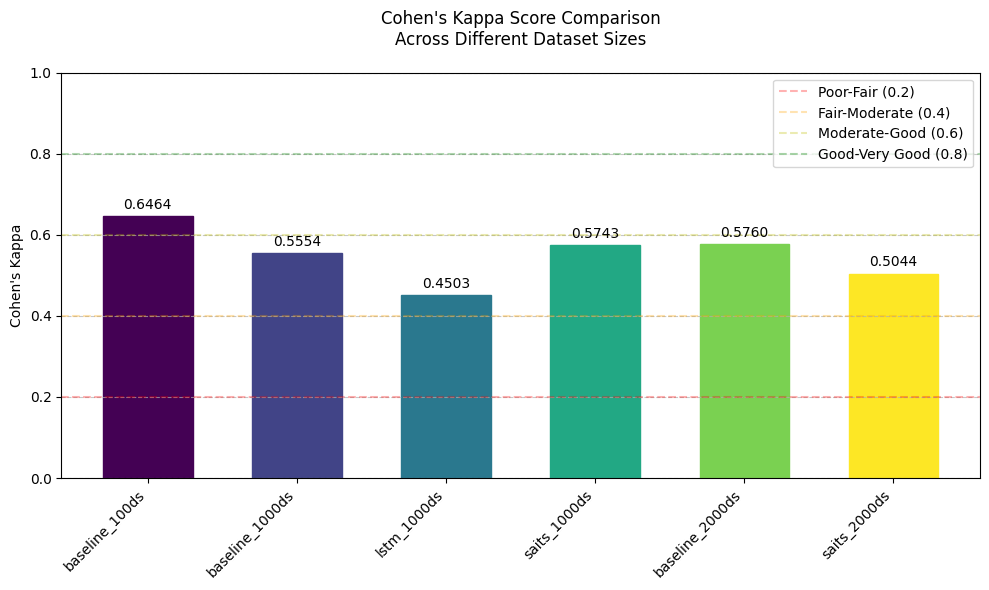


Kappa Score Interpretation Guide:
< 0.20: Poor agreement
0.20-0.40: Fair agreement
0.40-0.60: Moderate agreement
0.60-0.80: Good agreement
0.80-1.00: Very good agreement


In [2]:
# Calculate and visualize Cohen's Kappa scores
from sklearn.metrics import cohen_kappa_score

def calculate_kappa_for_experiment(metrics):
    """
    Calculate Cohen's Kappa score for a single experiment using the classification report metrics.
    Uses a more robust approach to construct the confusion matrix.
    """
    # Get all classes (excluding special keys)
    classes = [k for k in metrics.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']]
    
    # Create confusion matrix
    n_classes = len(classes)
    confusion_matrix = np.zeros((n_classes, n_classes))
    
    # Fill in confusion matrix using precision, recall, and support
    class_to_idx = {c: i for i, c in enumerate(classes)}
    
    total_samples = 0
    for true_class in classes:
        metrics_i = metrics[true_class]
        support = metrics_i['support']
        total_samples += support
        
        if support > 0:
            i = class_to_idx[true_class]
            
            # True positives
            tp = int(metrics_i['recall'] * support)
            confusion_matrix[i, i] = tp
            
            # False negatives (predicted as other classes)
            fn = support - tp
            if fn > 0:
                # Calculate weights for distributing false negatives
                weights = []
                for pred_class in classes:
                    if pred_class != true_class:
                        # Use (1 - precision) as weight for false predictions
                        weight = 1 - metrics[pred_class]['precision']
                        # Ensure non-negative weight
                        weight = max(0.1, weight)  # minimum weight of 0.1
                        weights.append((class_to_idx[pred_class], weight))
                
                # Normalize weights
                total_weight = sum(w for _, w in weights)
                if total_weight > 0:
                    # Distribute false negatives
                    remaining_fn = fn
                    for pred_idx, weight in weights[:-1]:  # Process all but last weight
                        fn_count = int(round((weight / total_weight) * fn))
                        fn_count = min(fn_count, remaining_fn)  # Don't exceed remaining FNs
                        confusion_matrix[i, pred_idx] = fn_count
                        remaining_fn -= fn_count
                    
                    # Put any remaining FNs in the last class
                    if remaining_fn > 0 and weights:
                        confusion_matrix[i, weights[-1][0]] = remaining_fn
    
    # Convert confusion matrix back to true and predicted labels
    y_true = []
    y_pred = []
    
    for i, true_class in enumerate(classes):
        for j, pred_class in enumerate(classes):
            count = int(confusion_matrix[i, j])
            if count > 0:
                y_true.extend([true_class] * count)
                y_pred.extend([pred_class] * count)
    
    return y_true, y_pred

# Calculate Kappa scores for all experiments
kappa_scores = []

for exp_name, json_path in EVAL_PATHS.items():
    print(f"\nProcessing {exp_name}...")
    
    with open(json_path, 'r') as f:
        eval_data = json.load(f)
    
    metrics = eval_data['classification_report']
    
    # Print some debug info
    print(f"Number of classes: {len([k for k in metrics.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']])}")
    print("Classes with support > 0:")
    for k, v in metrics.items():
        if k not in ['accuracy', 'macro avg', 'weighted avg']:
            if v['support'] > 0:
                print(f"{k}: support={v['support']}, recall={v['recall']:.4f}, precision={v['precision']:.4f}")
    
    # Calculate labels and kappa
    try:
        y_true, y_pred = calculate_kappa_for_experiment(metrics)
        print(f"Generated labels: {len(y_true)} true, {len(y_pred)} predicted")
        
        if len(y_true) > 0 and len(y_pred) > 0 and len(y_true) == len(y_pred):
            # Print unique labels to verify
            unique_true = set(y_true)
            unique_pred = set(y_pred)
            print(f"Unique true labels: {len(unique_true)}")
            print(f"Unique predicted labels: {len(unique_pred)}")
            
            kappa = cohen_kappa_score(y_true, y_pred)
            print(f"Calculated Kappa: {kappa:.4f}")
        else:
            print(f"Warning: Invalid number of predictions for {exp_name}")
            print(f"True labels: {len(y_true)}, Predicted labels: {len(y_pred)}")
            kappa = np.nan
    except Exception as e:
        print(f"Warning: Could not calculate Kappa for {exp_name}: {str(e)}")
        kappa = np.nan
    
    kappa_scores.append({
        'experiment': exp_name,
        'kappa': kappa
    })

# Sort experiments by dataset size and create visualization
def get_dataset_size(exp_name):
    try:
        return int(exp_name.split('_')[1].replace('ds', ''))
    except:
        return 0

# Create DataFrame and sort by dataset size
kappa_df = pd.DataFrame(kappa_scores)
kappa_df['dataset_size'] = kappa_df['experiment'].apply(get_dataset_size)
kappa_df = kappa_df.sort_values('dataset_size')

# Print the sorted scores
print("\nCohen's Kappa Scores (sorted by dataset size):")
print(kappa_df[['experiment', 'kappa']].round(4))

# Check if we have any valid scores
if kappa_df['kappa'].notna().any():
    # Create the visualization
    plt.figure(figsize=(10, 6))
    
    # Plot bars
    bars = plt.bar(range(len(kappa_df)), kappa_df['kappa'], width=0.6)
    
    # Customize colors based on dataset size
    colors = plt.cm.viridis(np.linspace(0, 1, len(kappa_df)))
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    # Customize x-axis
    plt.xticks(range(len(kappa_df)), kappa_df['experiment'], rotation=45, ha='right')
    
    # Customize y-axis
    plt.ylabel("Cohen's Kappa")
    plt.ylim(0, 1.0)  # Fixed y-limit since Kappa is always between -1 and 1
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add title
    plt.title("Cohen's Kappa Score Comparison\nAcross Different Dataset Sizes", pad=20)
    
    # Add value labels on top of each bar
    for i, v in enumerate(kappa_df['kappa']):
        if not np.isnan(v):
            plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
    
    # Add reference lines for interpretation
    plt.axhline(y=0.2, color='r', linestyle='--', alpha=0.3, label='Poor-Fair (0.2)')
    plt.axhline(y=0.4, color='orange', linestyle='--', alpha=0.3, label='Fair-Moderate (0.4)')
    plt.axhline(y=0.6, color='y', linestyle='--', alpha=0.3, label='Moderate-Good (0.6)')
    plt.axhline(y=0.8, color='g', linestyle='--', alpha=0.3, label='Good-Very Good (0.8)')
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(OUTPUT_DIR / 'cohens_kappa_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print interpretation guide
    print("\nKappa Score Interpretation Guide:")
    print("< 0.20: Poor agreement")
    print("0.20-0.40: Fair agreement")
    print("0.40-0.60: Moderate agreement")
    print("0.60-0.80: Good agreement")
    print("0.80-1.00: Very good agreement")
else:
    print("\nWarning: No valid Kappa scores to visualize. Please check the debug output above for details.")


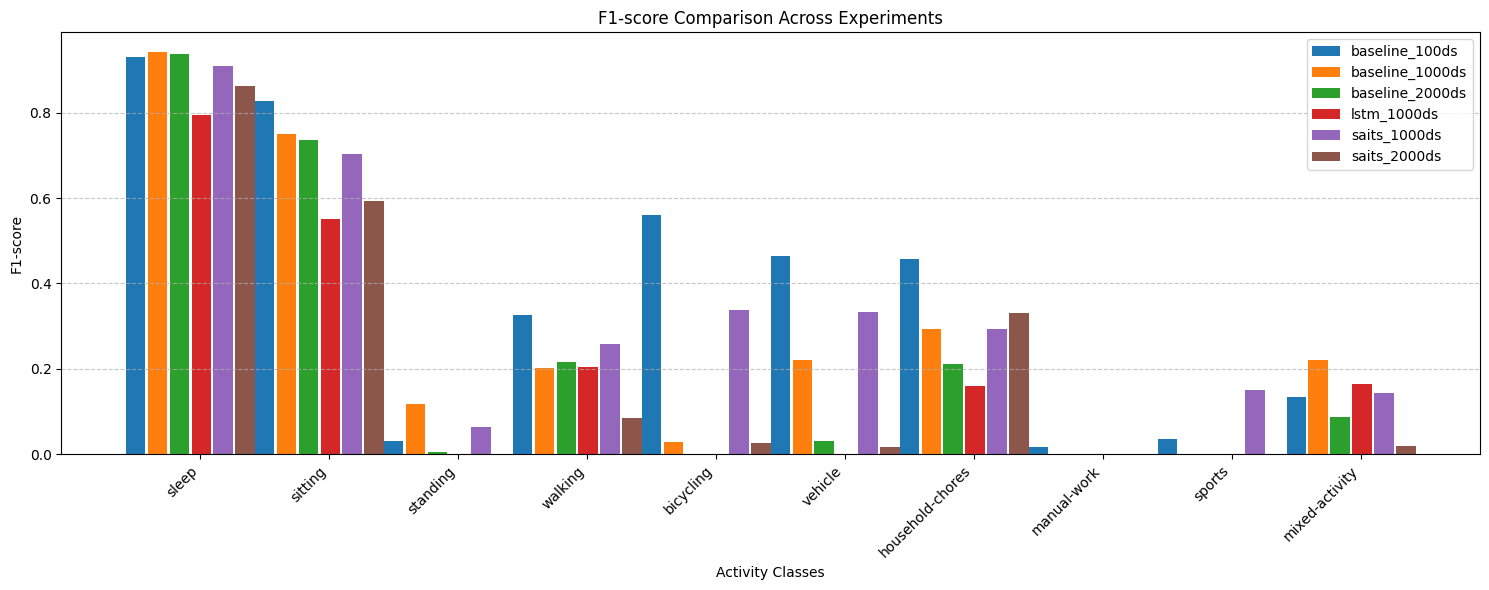

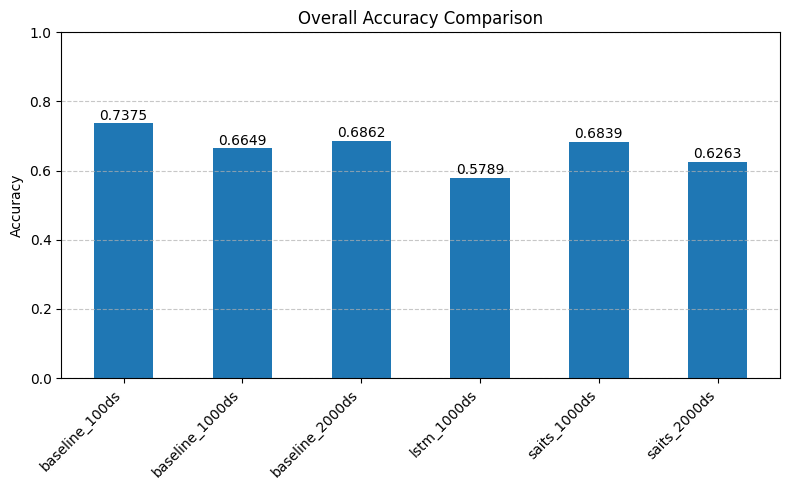

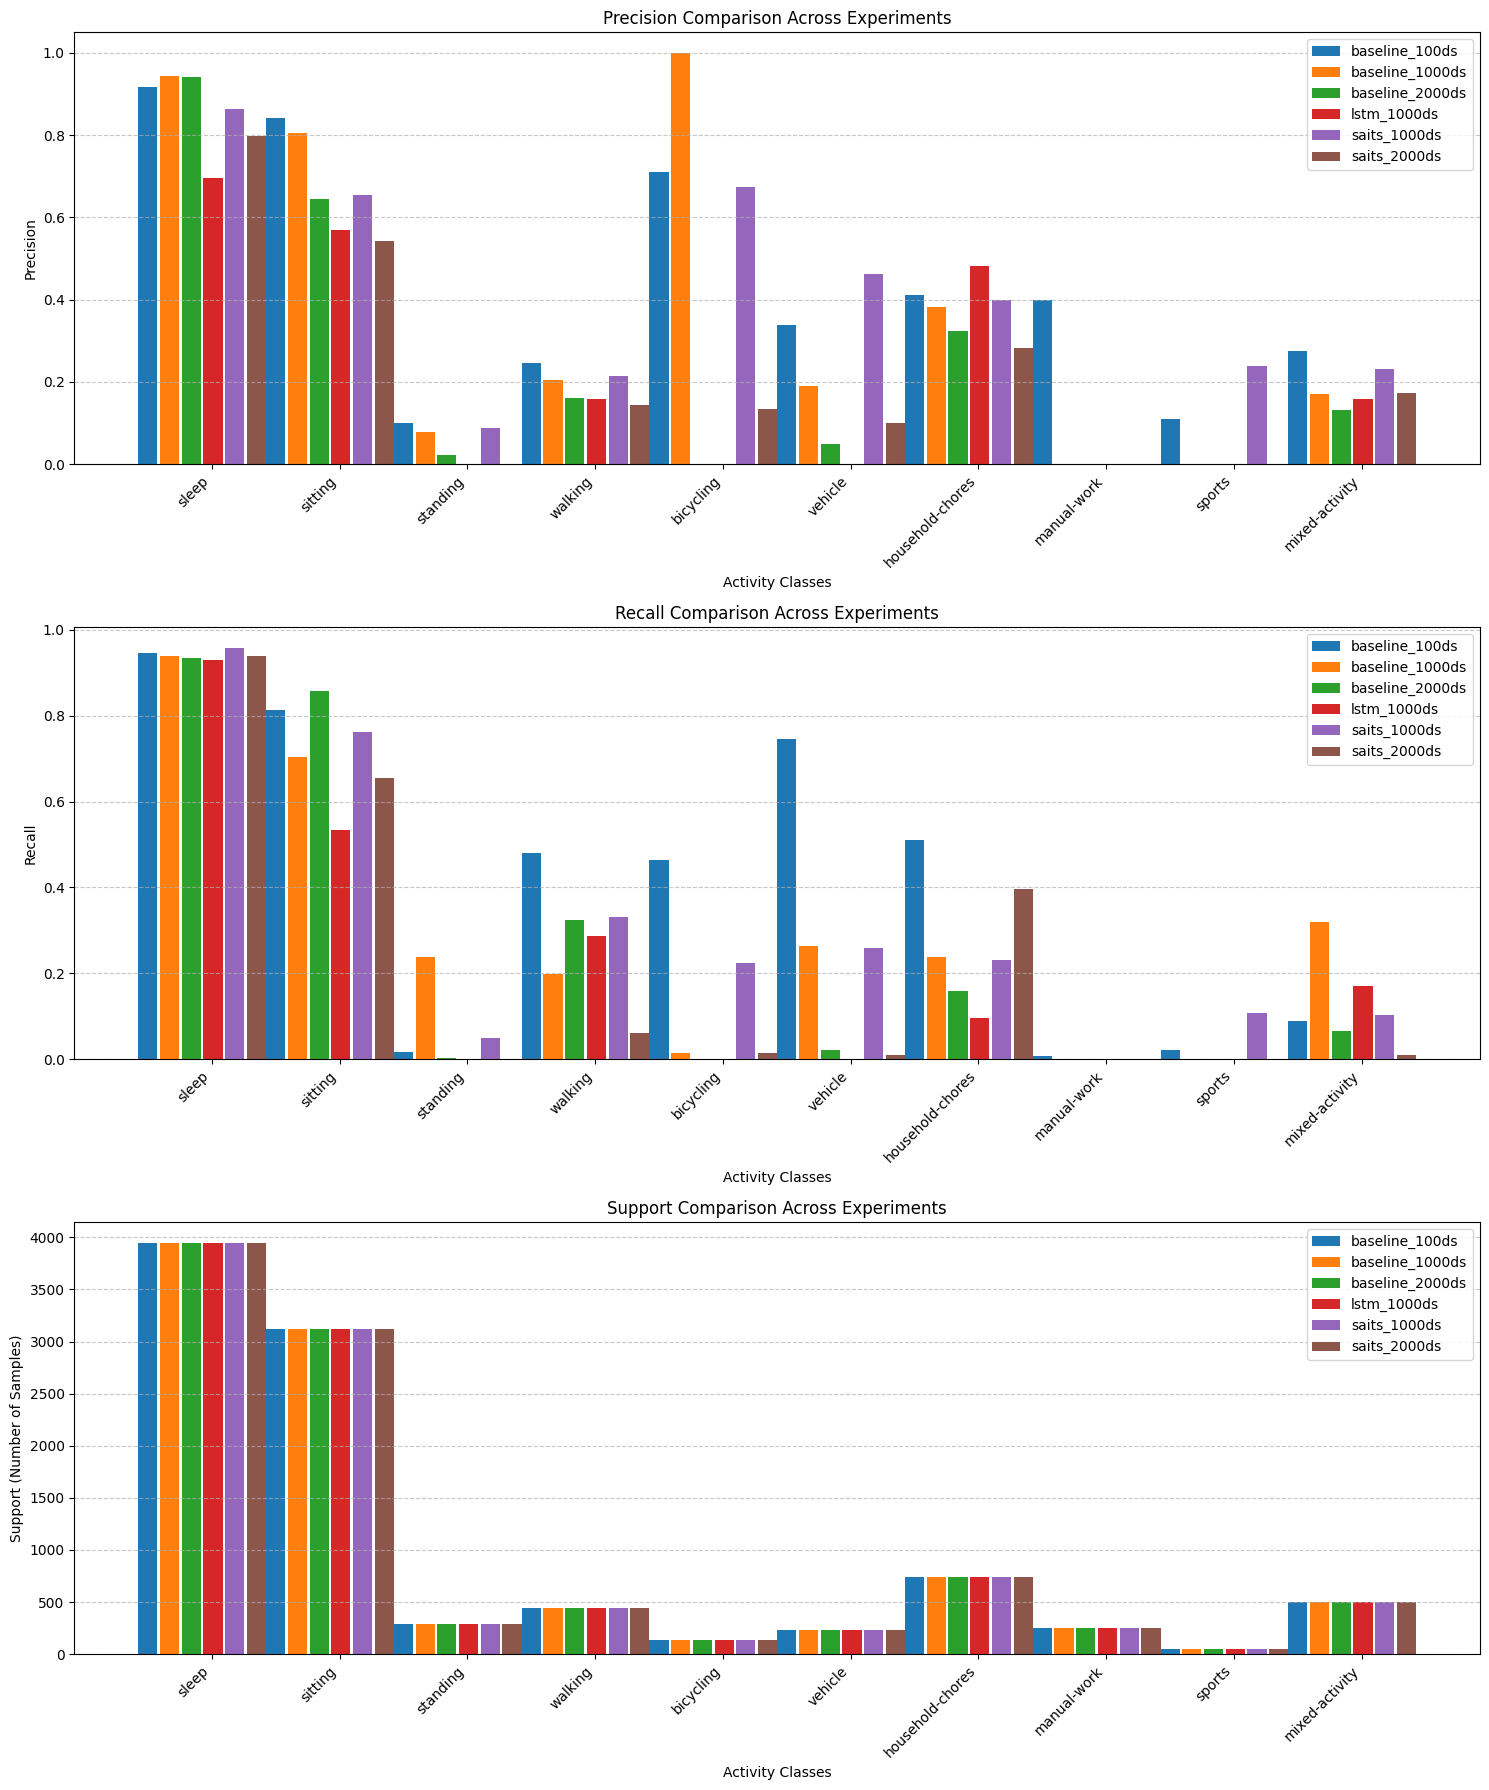


Saved plots to: /project/cc-20250120231604/ssd/users/kwsu/research/dsllm/dsllm/PAPER/paper_related_code/model_classification_results/figures
Files saved:
- f1_score_comparison.png
- accuracy_comparison.png
- precision_recall_support_comparison.png
- cohens_kappa_comparison.png


In [ ]:
# Save all plots as high-quality images
figures_dir = Path('/project/cc-20250120231604/ssd/users/kwsu/research/dsllm/dsllm/PAPER/paper_related_code/model_classification_results/figures')
figures_dir.mkdir(exist_ok=True)

# Process and compare all evaluation files
consolidated = []
accuracies = []

for exp_name, json_path in EVAL_PATHS.items():
    with open(json_path, 'r') as f:
        eval_data = json.load(f)
    metrics = eval_data['classification_report']
    
    # Store accuracy separately
    accuracies.append({
        'experiment': exp_name,
        'accuracy': eval_data['accuracy']
    })
    
    # Process per-class metrics
    class_metrics = {k: v for k, v in metrics.items() if k not in ['accuracy', 'macro avg', 'weighted avg']}
    metrics_df = pd.DataFrame.from_dict(class_metrics, orient='index')
    metrics_df['experiment'] = exp_name
    metrics_df = metrics_df.round(4)
    metrics_df['support'] = metrics_df['support'].astype(int)
    consolidated.append(metrics_df.reset_index().rename(columns={'index': 'class'}))

# Combine all results
plot_data = pd.concat(consolidated, ignore_index=True)

# Get list of experiments from evaluation paths
experiments = list(EVAL_PATHS.keys())
n_experiments = len(experiments)

# Get list of classes from first experiment's evaluation data
with open(list(EVAL_PATHS.values())[0], 'r') as f:
    first_eval_data = json.load(f)
classes = list(first_eval_data['classification_report'].keys())
classes = [c for c in classes if c not in ['accuracy', 'macro avg', 'weighted avg']]

# Set up bar chart parameters
width = 0.15
spacing = 0.02
indices = np.arange(len(classes))
offsets = [width * i + spacing * i for i in range(n_experiments)]

# Plot and save F1-score comparison
plt.figure(figsize=(15, 6))
for i, exp in enumerate(experiments):
    subset = plot_data[plot_data['experiment'] == exp]
    plt.bar(indices + offsets[i], subset['f1-score'], width, label=exp)
plt.xlabel('Activity Classes')
plt.ylabel('F1-score')
plt.title('F1-score Comparison Across Experiments')
plt.xticks(indices + (n_experiments * (width + spacing) - spacing) / 2, classes, rotation=45, ha='right')
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(figures_dir / 'f1_score_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Plot and save accuracy comparison
plt.figure(figsize=(8, 5))
accuracy_df = pd.DataFrame(accuracies)
plt.bar(range(len(accuracy_df)), accuracy_df['accuracy'], width=0.5)
plt.xticks(range(len(accuracy_df)), accuracy_df['experiment'], rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Overall Accuracy Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1.0)
for i, v in enumerate(accuracy_df['accuracy']):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.tight_layout()
plt.savefig(figures_dir / 'accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Plot and save precision/recall/support comparisons
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 18))

# Precision plot
for i, exp in enumerate(experiments):
    subset = plot_data[plot_data['experiment'] == exp]
    ax1.bar(indices + offsets[i], subset['precision'], width, label=exp)
ax1.set_xlabel('Activity Classes')
ax1.set_ylabel('Precision')
ax1.set_title('Precision Comparison Across Experiments')
ax1.set_xticks(indices + (n_experiments * (width + spacing) - spacing) / 2)
ax1.set_xticklabels(classes, rotation=45, ha='right')
ax1.legend(loc='upper right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Recall plot
for i, exp in enumerate(experiments):
    subset = plot_data[plot_data['experiment'] == exp]
    ax2.bar(indices + offsets[i], subset['recall'], width, label=exp)
ax2.set_xlabel('Activity Classes')
ax2.set_ylabel('Recall')
ax2.set_title('Recall Comparison Across Experiments')
ax2.set_xticks(indices + (n_experiments * (width + spacing) - spacing) / 2)
ax2.set_xticklabels(classes, rotation=45, ha='right')
ax2.legend(loc='upper right')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Support plot
for i, exp in enumerate(experiments):
    subset = plot_data[plot_data['experiment'] == exp]
    ax3.bar(indices + offsets[i], subset['support'], width, label=exp)
ax3.set_xlabel('Activity Classes')
ax3.set_ylabel('Support (Number of Samples)')
ax3.set_title('Support Comparison Across Experiments')
ax3.set_xticks(indices + (n_experiments * (width + spacing) - spacing) / 2)
ax3.set_xticklabels(classes, rotation=45, ha='right')
ax3.legend(loc='upper right')
ax3.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(figures_dir / 'precision_recall_support_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(f"\nSaved plots to: {figures_dir}")
print("Files saved:")
print("- f1_score_comparison.png")
print("- accuracy_comparison.png")
print("- precision_recall_support_comparison.png")
print("- cohens_kappa_comparison.png")


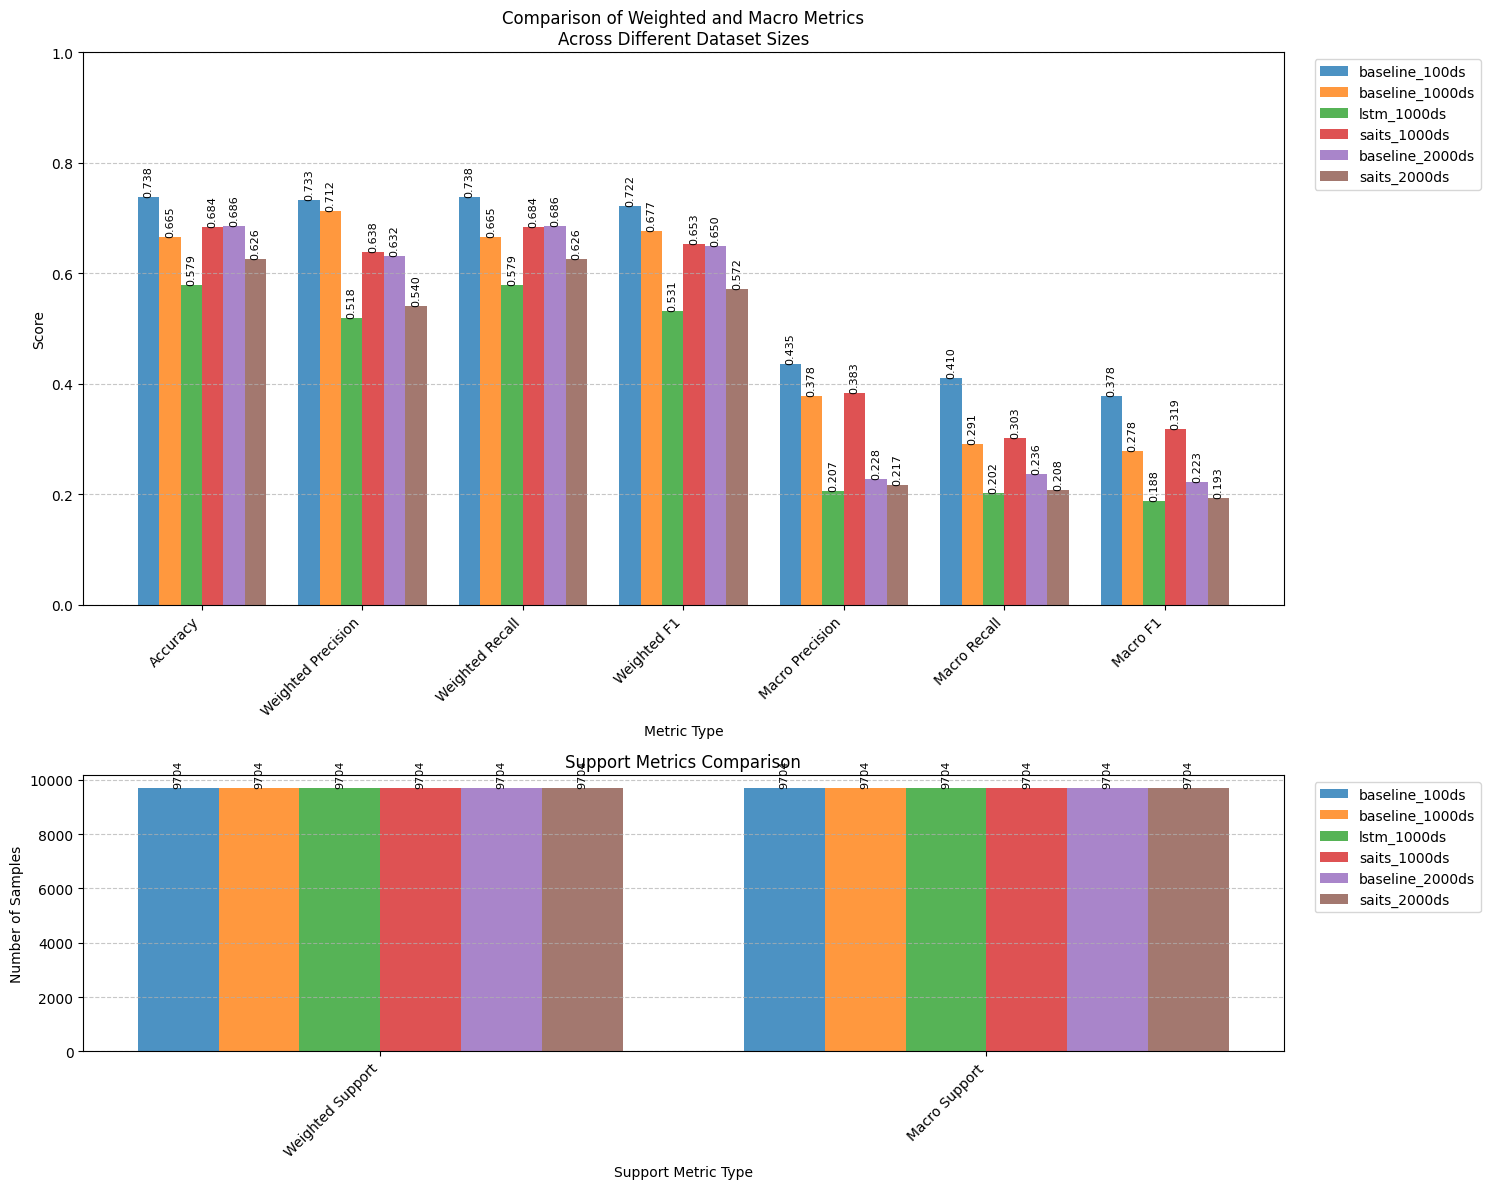


Saved plots to: /project/cc-20250120231604/ssd/users/kwsu/research/dsllm/dsllm/PAPER/paper_related_code/model_classification_results/figures
Files saved:
- f1_score_comparison.png
- accuracy_comparison.png
- precision_recall_support_comparison.png
- cohens_kappa_comparison.png
- weighted_metrics_comparison.png

Detailed Weighted and Macro Metrics:
     experiment  accuracy  weighted_precision  weighted_recall  weighted_f1  macro_precision  macro_recall  macro_f1  weighted_support  macro_support
 baseline_100ds    0.7375              0.7327           0.7375       0.7224           0.4352        0.4098    0.3784              9704           9704
baseline_1000ds    0.6649              0.7118           0.6649       0.6766           0.3777        0.2914    0.2777              9704           9704
    lstm_1000ds    0.5789              0.5184           0.5789       0.5309           0.2065        0.2017    0.1875              9704           9704
   saits_1000ds    0.6839              0.6384    

In [ ]:
# Create weighted metrics comparison plot
weighted_metrics = []

for exp_name, json_path in EVAL_PATHS.items():
    with open(json_path, 'r') as f:
        eval_data = json.load(f)
    
    # Extract weighted and macro averages
    metrics = eval_data['classification_report']
    weighted_metrics.append({
        'experiment': exp_name,
        'accuracy': eval_data['accuracy'],
        'weighted_precision': metrics['weighted avg']['precision'],
        'weighted_recall': metrics['weighted avg']['recall'],
        'weighted_f1': metrics['weighted avg']['f1-score'],
        'weighted_support': metrics['weighted avg']['support'],
        'macro_precision': metrics['macro avg']['precision'],
        'macro_recall': metrics['macro avg']['recall'],
        'macro_f1': metrics['macro avg']['f1-score'],
        'macro_support': metrics['macro avg']['support']
    })

# Convert to DataFrame for easier plotting
weighted_df = pd.DataFrame(weighted_metrics)

# Sort by dataset size for better visualization
def get_dataset_size(exp_name):
    try:
        return int(exp_name.split('_')[1].replace('ds', ''))
    except:
        return 0

weighted_df['dataset_size'] = weighted_df['experiment'].apply(get_dataset_size)
weighted_df = weighted_df.sort_values('dataset_size')

# Separate metrics into score metrics and support metrics
score_metrics = [
    ('accuracy', 'Accuracy'),
    ('weighted_precision', 'Weighted Precision'),
    ('weighted_recall', 'Weighted Recall'),
    ('weighted_f1', 'Weighted F1'),
    ('macro_precision', 'Macro Precision'),
    ('macro_recall', 'Macro Recall'),
    ('macro_f1', 'Macro F1')
]

support_metrics = [
    ('weighted_support', 'Weighted Support'),
    ('macro_support', 'Macro Support')
]

# Create two subplots: one for scores and one for support
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[2, 1])

# Plot 1: Score metrics
n_metrics = len(score_metrics)
n_experiments = len(weighted_df)
bar_width = 0.8 / n_experiments
positions = np.arange(n_metrics)

for i, (_, exp_row) in enumerate(weighted_df.iterrows()):
    offset = (i - n_experiments/2 + 0.5) * bar_width
    values = [exp_row[m[0]] for m in score_metrics]
    bars = ax1.bar(positions + offset, 
                   values, 
                   bar_width, 
                   label=exp_row['experiment'],
                   alpha=0.8)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height,
                f'{height:.3f}',
                ha='center', va='bottom',
                rotation=90,
                fontsize=8)

# Customize first plot
ax1.set_xlabel('Metric Type')
ax1.set_ylabel('Score')
ax1.set_title('Comparison of Weighted and Macro Metrics\nAcross Different Dataset Sizes')
ax1.set_xticks(positions)
ax1.set_xticklabels([m[1] for m in score_metrics], rotation=45, ha='right')
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_ylim(0, 1.0)

# Plot 2: Support metrics
n_metrics = len(support_metrics)
positions = np.arange(n_metrics)

for i, (_, exp_row) in enumerate(weighted_df.iterrows()):
    offset = (i - n_experiments/2 + 0.5) * bar_width
    values = [exp_row[m[0]] for m in support_metrics]
    bars = ax2.bar(positions + offset, 
                   values, 
                   bar_width, 
                   label=exp_row['experiment'],
                   alpha=0.8)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height,
                f'{int(height)}',
                ha='center', va='bottom',
                rotation=90,
                fontsize=8)

# Customize second plot
ax2.set_xlabel('Support Metric Type')
ax2.set_ylabel('Number of Samples')
ax2.set_title('Support Metrics Comparison')
ax2.set_xticks(positions)
ax2.set_xticklabels([m[1] for m in support_metrics], rotation=45, ha='right')
ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save plot
plt.savefig(figures_dir / 'weighted_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Print updated files list
print("\nSaved plots to:", figures_dir)
print("Files saved:")
print("- f1_score_comparison.png")
print("- accuracy_comparison.png")
print("- precision_recall_support_comparison.png")
print("- cohens_kappa_comparison.png")
print("- weighted_metrics_comparison.png")

# Display the metrics in a table format
print("\nDetailed Weighted and Macro Metrics:")
display_cols = ['experiment'] + [m[0] for m in score_metrics + support_metrics]
# Format the DataFrame: round score metrics to 4 decimals, show support as integers
formatted_df = weighted_df[display_cols].copy()
for col in [m[0] for m in score_metrics]:
    formatted_df[col] = formatted_df[col].round(4)
for col in [m[0] for m in support_metrics]:
    formatted_df[col] = formatted_df[col].astype(int)
print(formatted_df.to_string(index=False))


Saved per-class metrics comparison to: /project/cc-20250120231604/ssd/users/kwsu/research/dsllm/dsllm/PAPER/paper_related_code/model_classification_results/figures/per_class_metrics_comparison.csv

Saved weighted metrics to: /project/cc-20250120231604/ssd/users/kwsu/research/dsllm/dsllm/PAPER/paper_related_code/model_classification_results/figures/weighted_metrics_comparison.csv


<Figure size 2000x500 with 0 Axes>

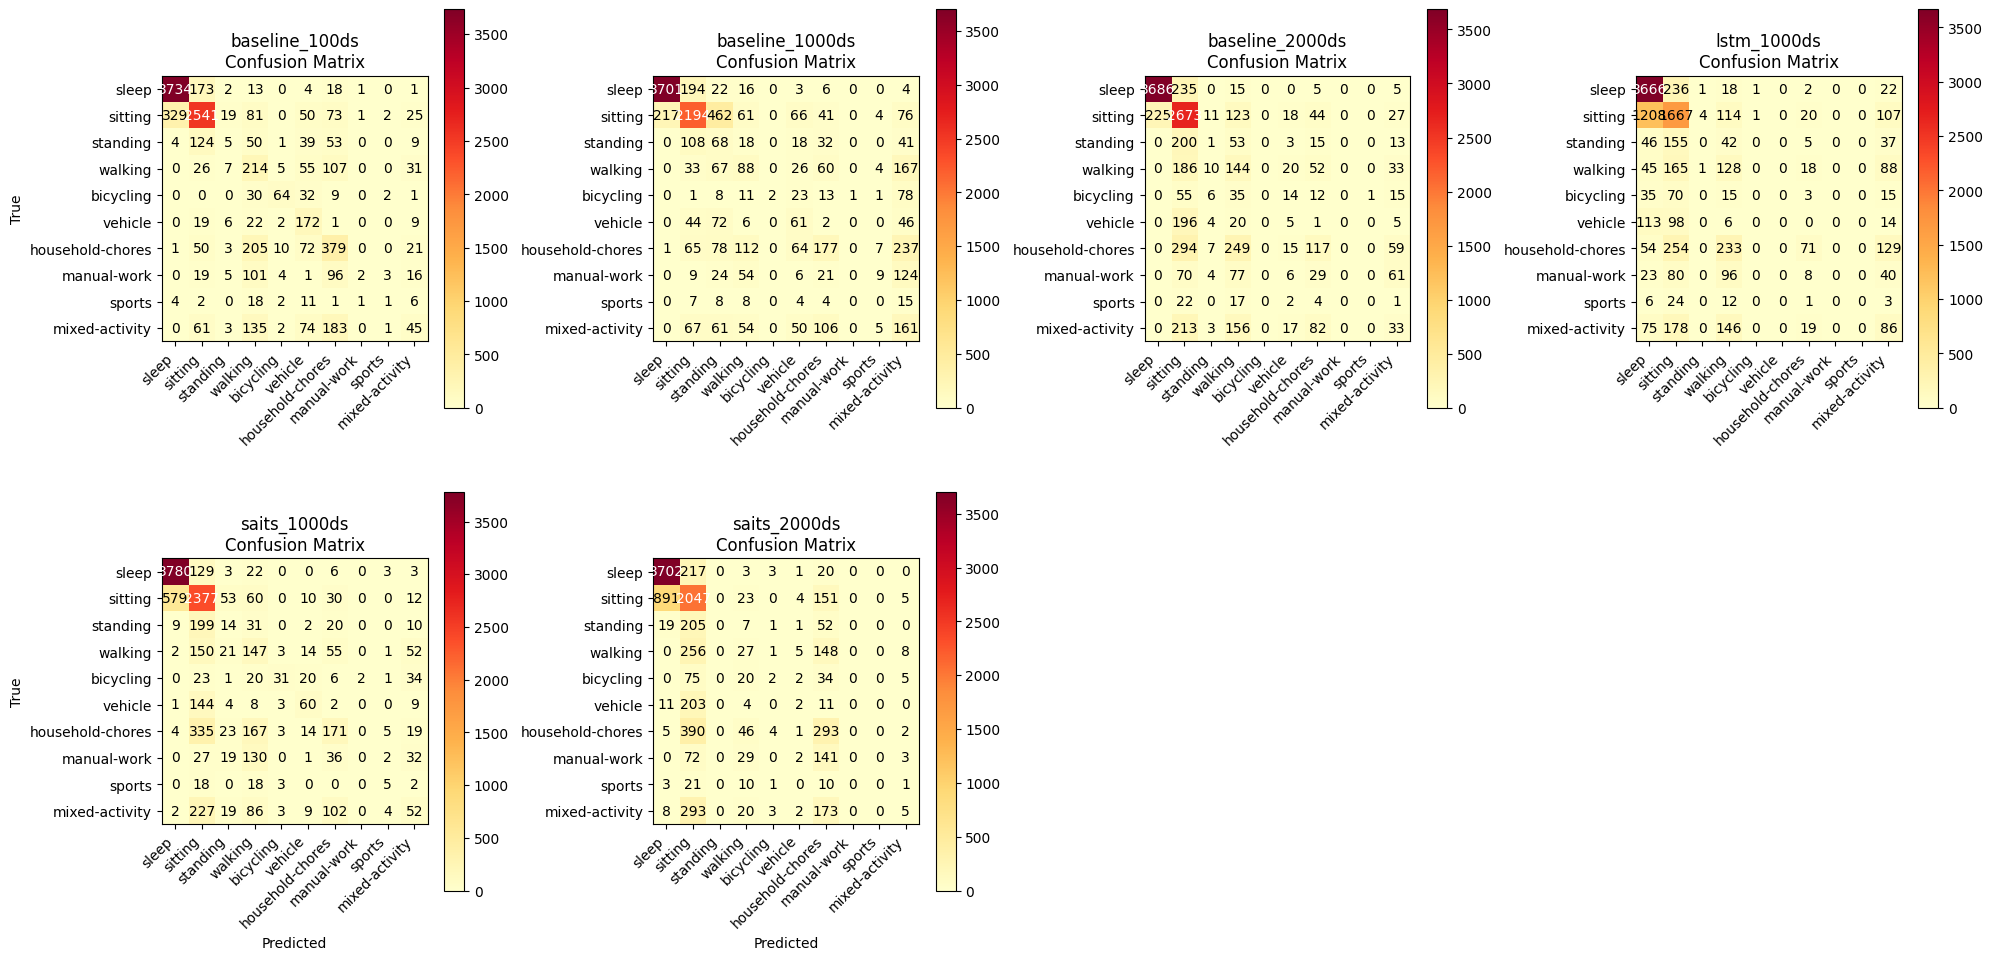


Updated files saved:
- f1_score_comparison.png
- accuracy_comparison.png
- precision_recall_comparison.png
- cohens_kappa_comparison.png
- weighted_metrics_comparison.png
- weighted_metrics_comparison.csv
- confusion_matrices_comparison.png


In [5]:
# Save per-class metrics for every experiment as a CSV
per_class_csv_path = figures_dir / 'per_class_metrics_comparison.csv'
plot_data.to_csv(per_class_csv_path, index=False)
print(f"Saved per-class metrics comparison to: {per_class_csv_path}")

# Save weighted metrics to CSV
csv_path = figures_dir / 'weighted_metrics_comparison.csv'
weighted_df.to_csv(csv_path, index=False)
print(f"\nSaved weighted metrics to: {csv_path}")

# Create side-by-side confusion matrices
plt.figure(figsize=(20, 5))

# Calculate number of subplots needed
n_plots = len(EVAL_PATHS)
n_cols = min(4, n_plots)  # Max 4 plots per row
n_rows = (n_plots + n_cols - 1) // n_cols

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)  # Ensure axes is 2D

# Process each experiment
for idx, (exp_name, json_path) in enumerate(EVAL_PATHS.items()):
    row = idx // n_cols
    col = idx % n_cols
    
    with open(json_path, 'r') as f:
        eval_data = json.load(f)
    
    # Get confusion matrix
    conf_matrix = np.array(eval_data['confusion_matrix'])
    
    # Get class names (excluding special keys)
    classes = [k for k in eval_data['classification_report'].keys() 
              if k not in ['accuracy', 'macro avg', 'weighted avg']]
    
    # Plot confusion matrix
    im = axes[row, col].imshow(conf_matrix, cmap='YlOrRd')
    
    # Add title
    axes[row, col].set_title(f'{exp_name}\nConfusion Matrix')
    
    # Add labels
    axes[row, col].set_xticks(np.arange(len(classes)))
    axes[row, col].set_yticks(np.arange(len(classes)))
    axes[row, col].set_xticklabels(classes, rotation=45, ha='right')
    axes[row, col].set_yticklabels(classes)
    
    # Add colorbar
    plt.colorbar(im, ax=axes[row, col])
    
    # Add text annotations
    for i in range(len(classes)):
        for j in range(len(classes)):
            text = axes[row, col].text(j, i, conf_matrix[i, j],
                                     ha="center", va="center", 
                                     color="black" if conf_matrix[i, j] < conf_matrix.max()/2 else "white")
    
    # Add axis labels
    if row == n_rows-1:
        axes[row, col].set_xlabel('Predicted')
    if col == 0:
        axes[row, col].set_ylabel('True')

# Remove empty subplots if any
for idx in range(len(EVAL_PATHS), n_rows*n_cols):
    row = idx // n_cols
    col = idx % n_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.savefig(figures_dir / 'confusion_matrices_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("\nUpdated files saved:")
print("- f1_score_comparison.png")
print("- accuracy_comparison.png")
print("- precision_recall_comparison.png")
print("- cohens_kappa_comparison.png")
print("- weighted_metrics_comparison.png")
print("- weighted_metrics_comparison.csv")
print("- confusion_matrices_comparison.png")
